### Load the dataset

In [314]:
!pip install -q -U einops datasets matplotlib tqdm


In [315]:
from torch import nn
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.transforms import ToTensor
import numpy as np
from torch.optim import Adam

In [316]:
class GELUConvBlock(nn.Module):
    def __init__(
        self, in_ch, out_ch, group_size):
        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, 3, 1, 1),
            nn.GroupNorm(group_size, out_ch),
            nn.GELU()
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [317]:
class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs, group_size):
        super().__init__()
        self.rearrange = Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2)
        self.conv = GELUConvBlock(4 * in_chs, in_chs, group_size)

    def forward(self, x):
        x = self.rearrange(x)
        return self.conv(x)

In [318]:
class DownBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super(DownBlock, self).__init__()
        layers = [
            GELUConvBlock(in_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            RearrangePoolBlock(out_chs, group_size)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [319]:
class UpBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super(UpBlock, self).__init__()
        layers = [
            nn.ConvTranspose2d(2 * in_chs, out_chs, 2, 2),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x

In [320]:
class EmbedBlock(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedBlock, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
            nn.Unflatten(1, (emb_dim, 1, 1))
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)

In [321]:
import math

class SinusoidalPositionEmbedBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [322]:
class ResidualConvBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()
        self.conv1 = GELUConvBlock(in_chs, out_chs, group_size)
        self.conv2 = GELUConvBlock(out_chs, out_chs, group_size)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        out = x1 + x2
        return out

In [323]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()


True

In [324]:
import torch
import torchvision
from torchvision.transforms import Resize, Compose, ToTensor, Lambda, ToPILImage

import math
from inspect import isfunction
from functools import partial
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange, reduce
from einops.layers.torch import Rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F

IMG_SIZE = 28
IMG_CH = 1
BATCH_SIZE = 128
N_CLASSES = torch.tensor(10).to(device)

nrows = 10
ncols = 15

T = nrows * ncols
start = 0.0001
end = 0.02
B = torch.linspace(start, end, T).to(device)

def load_dataset_with_transform(image_size):
    data_transforms = Compose([
        ToTensor(),
    ])

    dataset = torchvision.datasets.MNIST('./data/', transform=data_transforms, download=True)

    data_loader = torch.utils.data.DataLoader(dataset,
                                            batch_size=BATCH_SIZE,
                                            shuffle=True,
                                            num_workers=0)
    return data_loader

data = load_dataset_with_transform(28)

In [325]:
def get_context_mask(c, drop_prob):
    c_hot = F.one_hot(c.to(torch.int64), num_classes=N_CLASSES).to(device)
    c_mask = torch.bernoulli(torch.ones_like(c_hot).float() - drop_prob).to(device)
    return c_hot, c_mask

In [326]:
class UNet(nn.Module):
    def __init__(
        self, T, img_ch, img_size, down_chs=(64, 64, 128), t_embed_dim=8, c_embed_dim=10
    ):
        super().__init__()
        self.T = T
        up_chs = down_chs[::-1]  # Reverse of the down channels
        latent_image_size = img_size // 4  # 2 ** (len(down_chs) - 1)
        small_group_size = 8
        big_group_size = 32

        # Inital convolution
        self.down0 = ResidualConvBlock(img_ch, down_chs[0], small_group_size)

        # Downsample
        self.down1 = DownBlock(down_chs[0], down_chs[1], big_group_size)
        self.down2 = DownBlock(down_chs[1], down_chs[2], big_group_size)
        self.to_vec = nn.Sequential(nn.Flatten(), nn.GELU())

        # Embeddings
        self.dense_emb = nn.Sequential(
            nn.Linear(down_chs[2] * latent_image_size**2, down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[2] * latent_image_size**2),
            nn.ReLU(),
        )
        self.sinusoidaltime = SinusoidalPositionEmbedBlock(t_embed_dim)
        self.t_emb1 = EmbedBlock(t_embed_dim, up_chs[0])
        self.t_emb2 = EmbedBlock(t_embed_dim, up_chs[1])
        self.c_embed1 = EmbedBlock(c_embed_dim, up_chs[0])
        self.c_embed2 = EmbedBlock(c_embed_dim, up_chs[1])

        # Upsample
        self.up0 = nn.Sequential(
            nn.Unflatten(1, (up_chs[0], latent_image_size, latent_image_size)),
            GELUConvBlock(up_chs[0], up_chs[0], big_group_size),
        )
        self.up1 = UpBlock(up_chs[0], up_chs[1], big_group_size)
        self.up2 = UpBlock(up_chs[1], up_chs[2], big_group_size)

        # Match output channels and one last concatenation
        self.out = nn.Sequential(
            nn.Conv2d(2 * up_chs[-1], up_chs[-1], 3, 1, 1),
            nn.GroupNorm(small_group_size, up_chs[-1]),
            nn.ReLU(),
            nn.Conv2d(up_chs[-1], img_ch, 3, 1, 1),
        )

    def forward(self, x, t, c, c_mask):
        down0 = self.down0(x)
        down1 = self.down1(down0)
        down2 = self.down2(down1)
        latent_vec = self.to_vec(down2)

        latent_vec = self.dense_emb(latent_vec)
        t = t.float() / self.T  # Convert from [0, T] to [0, 1]
        t = self.sinusoidaltime(t)
        t_emb1 = self.t_emb1(t)
        t_emb2 = self.t_emb2(t)

        c = c * c_mask
        c_emb1 = self.c_embed1(c)
        c_emb2 = self.c_embed2(c)

        up0 = self.up0(latent_vec)
        up1 = self.up1(c_emb1 * up0 + t_emb1, down2)
        up2 = self.up2(c_emb2 * up1 + t_emb2, down1)
        return self.out(torch.cat((up2, down0), 1))

model = UNet(
    T, IMG_CH, IMG_SIZE, down_chs=(64, 64, 128), t_embed_dim=8, c_embed_dim=N_CLASSES
).to(device)
print("Num params: ", sum(p.numel() for p in model.parameters()))


Num params:  2547457


### Loss function for noise
Inorder to predict noise, we can MSE mechanism to find the loss between original image and when noise is added.

In the example below, an image is taken and noise is added to it at various timesteps.

The loss function calcualtes the image data loss with the original and its increase as in the curve

In [327]:
# image at certain step directly
a = 1. - B
beta = B
iters = len(beta)
alpha = a
alpha_cumu_prod = torch.cumprod(alpha, dim=0)
sqrt_a_bar = torch.sqrt(alpha_cumu_prod).to(device)  # Mean Coefficient
sqrt_one_minus_a_bar = torch.sqrt(1 - alpha_cumu_prod).to(device) # St. Dev. Coefficient

def getImageAtIter(x_0, t):
    t = t.int()
    noise = torch.randn_like(x_0)
    sqrt_a_bar_t = sqrt_a_bar[t, None, None, None]
    sqrt_one_minus_a_bar_t = sqrt_one_minus_a_bar[t, None, None, None]

    x_t = sqrt_a_bar_t * x_0 + sqrt_one_minus_a_bar_t * noise
    return x_t, noise

def loss_fun(a,b):
    return torch.nn.MSELoss()(a,b)

plt.figure(figsize=(8, 8))
x_0 = next(iter(data))[0][0].to(device)  # Initial image
x_t = x_0  # Set up recursion
xs = []  # Store x_t for each T to see change

for t in range(T):
    noise = torch.randn_like(x_t)
    x_t = torch.sqrt(1 - B[t]) * x_t + torch.sqrt(B[t]) * noise
    img = torch.squeeze(x_t).cpu()
    xs.append(img)
    ax = plt.subplot(nrows, ncols, t + 1)
    ax.axis("off")
    plt.imshow(img)
plt.savefig("forward_diffusion.png", bbox_inches="tight")

The loss function can be used along with adam optimizer ar lr=0.0001 to learn about the loss.

In [328]:
sqrt_a_inv = torch.sqrt(1 / alpha)
pred_noise_coeff = (1 - alpha) / torch.sqrt(1 - alpha_cumu_prod)

@torch.no_grad()
def reverse_q(x_t, t, e_t):
    t = torch.squeeze(t[0].int())  # All t values should be the same
    pred_noise_coeff_t = pred_noise_coeff[t]
    sqrt_a_inv_t = sqrt_a_inv[t]
    u_t = sqrt_a_inv_t * (x_t - pred_noise_coeff_t * e_t)
    if t == 0:
        return u_t  # Reverse diffusion complete!
    else:
        B_t = beta[t-1]
        new_noise = torch.randn_like(x_t)
        return u_t + torch.sqrt(B_t) * new_noise

In [329]:
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: torch.minimum(torch.tensor([1]), t)),
        transforms.Lambda(lambda t: torch.maximum(torch.tensor([0]), t)),
        transforms.ToPILImage(),
    ])
    plt.imshow(reverse_transforms(image[0].detach().cpu()))

@torch.no_grad()
def q(x_0, t):
    t = t.int()
    noise = torch.randn_like(x_0)
    sqrt_a_bar_t = sqrt_a_bar[t, None, None, None]
    sqrt_one_minus_a_bar_t = sqrt_one_minus_a_bar[t, None, None, None]

    x_t = sqrt_a_bar_t * x_0 + sqrt_one_minus_a_bar_t * noise
    return x_t, noise

def get_loss(model, x_0, t, *model_args):
    x_noisy, noise = q(x_0, t)
    noise_pred = model(x_noisy, t, *model_args)
    return F.mse_loss(noise, noise_pred)

@torch.no_grad()
def sample_images(model, img_ch, img_size, ncols, *model_args, axis_on=False):
    # Noise to generate images from
    x_t = torch.randn((1, img_ch, img_size, img_size), device=device)
    plt.figure(figsize=(8, 8))
    hidden_rows = T / ncols
    plot_number = 1

    # Go from T to 0 removing and adding noise until t = 0
    for i in range(0, T)[::-1]:
        t = torch.full((1,), i, device=device).float()
        e_t = model(x_t, t, *model_args)  # Predicted noise
        x_t = reverse_q(x_t, t, e_t)
        if i % hidden_rows == 0:
            ax = plt.subplot(1, ncols+1, plot_number)
            if not axis_on:
                ax.axis('off')
            show_tensor_image(x_t.detach().cpu())
            plot_number += 1
    plt.show()

In [330]:
class_names = [i for i in range(10)]
class_names

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

<generator object Module.parameters at 0x7dbd3f812c70>
Epoch 0 | Step 000 | Loss: 0.037144482135772705 | C: 0


Epoch 0 | Step 100 | Loss: 0.0359647162258625 | C: 1


Epoch 0 | Step 200 | Loss: 0.03497658297419548 | C: 2


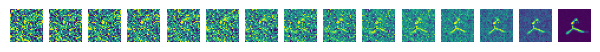

Epoch 0 | Step 300 | Loss: 0.035111039876937866 | C: 3


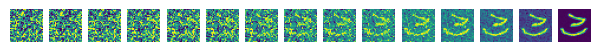

Epoch 0 | Step 400 | Loss: 0.03539172559976578 | C: 4


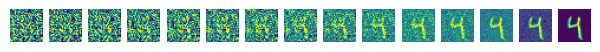

Epoch 1 | Step 000 | Loss: 0.03296530991792679 | C: 5


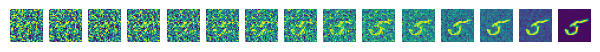

Epoch 1 | Step 100 | Loss: 0.03536853939294815 | C: 6


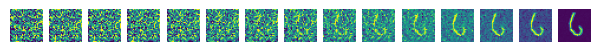

Epoch 1 | Step 200 | Loss: 0.03423532471060753 | C: 7


Epoch 1 | Step 300 | Loss: 0.03125075250864029 | C: 8


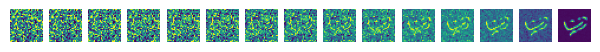

Epoch 1 | Step 400 | Loss: 0.035978347063064575 | C: 9


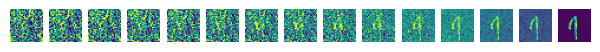

Epoch 2 | Step 000 | Loss: 0.03395754471421242 | C: 0


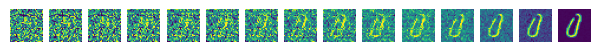

Epoch 2 | Step 100 | Loss: 0.035874273627996445 | C: 1


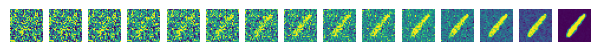

Epoch 2 | Step 200 | Loss: 0.03391110524535179 | C: 2


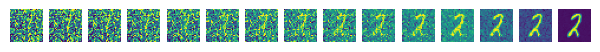

Epoch 2 | Step 300 | Loss: 0.03496214747428894 | C: 3


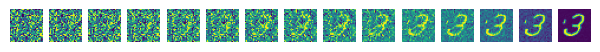

Epoch 2 | Step 400 | Loss: 0.0314435176551342 | C: 4


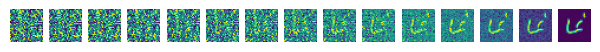

Epoch 3 | Step 000 | Loss: 0.03607207164168358 | C: 5


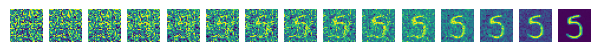

Epoch 3 | Step 100 | Loss: 0.03648166358470917 | C: 6


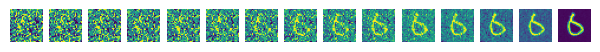

Epoch 3 | Step 200 | Loss: 0.03870972618460655 | C: 7


Epoch 3 | Step 300 | Loss: 0.03500281646847725 | C: 8


Epoch 3 | Step 400 | Loss: 0.035673219710588455 | C: 9


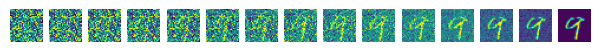

Epoch 4 | Step 000 | Loss: 0.029932299628853798 | C: 0


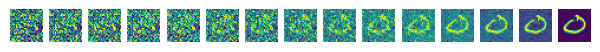

Epoch 4 | Step 100 | Loss: 0.032943256199359894 | C: 1


Epoch 4 | Step 200 | Loss: 0.030772550031542778 | C: 2


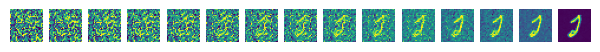

Epoch 4 | Step 300 | Loss: 0.03482808172702789 | C: 3


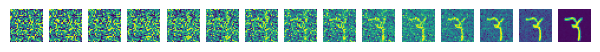

Epoch 4 | Step 400 | Loss: 0.03595852106809616 | C: 4


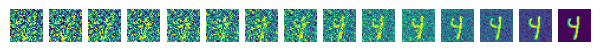

Epoch 5 | Step 000 | Loss: 0.033901363611221313 | C: 5


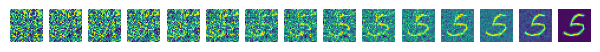

Epoch 5 | Step 100 | Loss: 0.03160542622208595 | C: 6


Epoch 5 | Step 200 | Loss: 0.032697923481464386 | C: 7


Epoch 5 | Step 300 | Loss: 0.0296612735837698 | C: 8


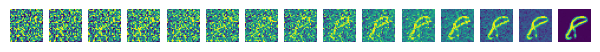

Epoch 5 | Step 400 | Loss: 0.036081425845623016 | C: 9


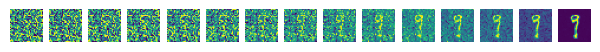

Epoch 6 | Step 000 | Loss: 0.0302592683583498 | C: 0


Epoch 6 | Step 100 | Loss: 0.03495229035615921 | C: 1


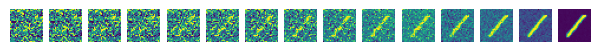

Epoch 6 | Step 200 | Loss: 0.034495819360017776 | C: 2


Epoch 6 | Step 300 | Loss: 0.03599175438284874 | C: 3


Epoch 6 | Step 400 | Loss: 0.03719377890229225 | C: 4


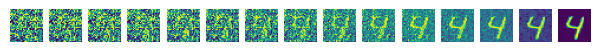

Epoch 7 | Step 000 | Loss: 0.031124141067266464 | C: 5


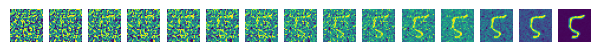

Epoch 7 | Step 100 | Loss: 0.032457754015922546 | C: 6


Epoch 7 | Step 200 | Loss: 0.030683089047670364 | C: 7


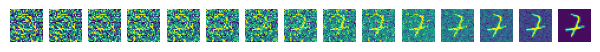

Epoch 7 | Step 300 | Loss: 0.034043777734041214 | C: 8


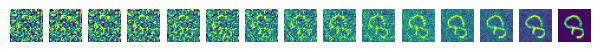

Epoch 7 | Step 400 | Loss: 0.03357692435383797 | C: 9


Epoch 8 | Step 000 | Loss: 0.03220472112298012 | C: 0


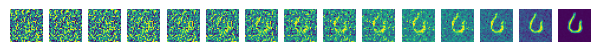

Epoch 8 | Step 100 | Loss: 0.03500433266162872 | C: 1


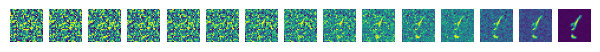

Epoch 8 | Step 200 | Loss: 0.034361112862825394 | C: 2


Epoch 8 | Step 300 | Loss: 0.03396683186292648 | C: 3


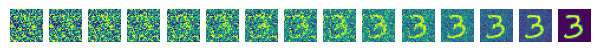

Epoch 8 | Step 400 | Loss: 0.03900044783949852 | C: 4


Epoch 9 | Step 000 | Loss: 0.02914995513856411 | C: 5


Epoch 9 | Step 100 | Loss: 0.03164062276482582 | C: 6


Epoch 9 | Step 200 | Loss: 0.03360434249043465 | C: 7


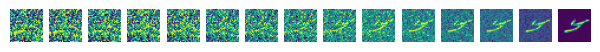

Epoch 9 | Step 300 | Loss: 0.029427420347929 | C: 8


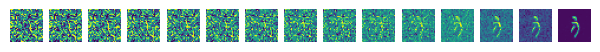

Epoch 9 | Step 400 | Loss: 0.031156349927186966 | C: 9


Epoch 10 | Step 000 | Loss: 0.034444667398929596 | C: 0


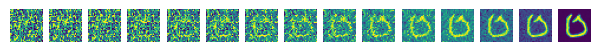

Epoch 10 | Step 100 | Loss: 0.033267706632614136 | C: 1


Epoch 10 | Step 200 | Loss: 0.036999158561229706 | C: 2


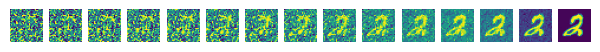

Epoch 10 | Step 300 | Loss: 0.033949535340070724 | C: 3


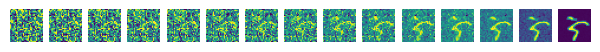

Epoch 10 | Step 400 | Loss: 0.03321397304534912 | C: 4


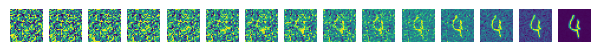

Epoch 11 | Step 000 | Loss: 0.032791174948215485 | C: 5


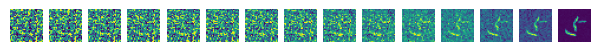

Epoch 11 | Step 100 | Loss: 0.031231753528118134 | C: 6


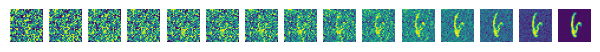

Epoch 11 | Step 200 | Loss: 0.030324634164571762 | C: 7


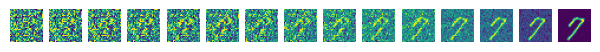

Epoch 11 | Step 300 | Loss: 0.04202239587903023 | C: 8


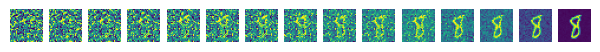

Epoch 11 | Step 400 | Loss: 0.03400246426463127 | C: 9


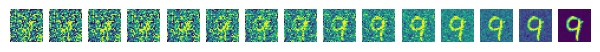

Epoch 12 | Step 000 | Loss: 0.0344490222632885 | C: 0


Epoch 12 | Step 100 | Loss: 0.0327562615275383 | C: 1


Epoch 12 | Step 200 | Loss: 0.034609705209732056 | C: 2


Epoch 12 | Step 300 | Loss: 0.0358218178153038 | C: 3


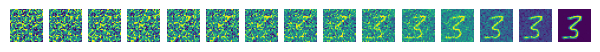

Epoch 12 | Step 400 | Loss: 0.03676734119653702 | C: 4


Epoch 13 | Step 000 | Loss: 0.03352973982691765 | C: 5


Epoch 13 | Step 100 | Loss: 0.0343191884458065 | C: 6


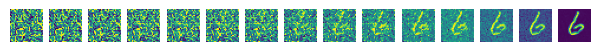

Epoch 13 | Step 200 | Loss: 0.034480366855859756 | C: 7


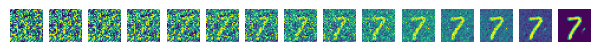

Epoch 13 | Step 300 | Loss: 0.030188579112291336 | C: 8


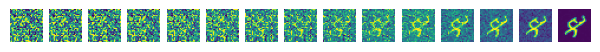

Epoch 13 | Step 400 | Loss: 0.0335790291428566 | C: 9


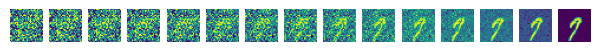

Epoch 14 | Step 000 | Loss: 0.03653373941779137 | C: 0


Epoch 14 | Step 100 | Loss: 0.034742262214422226 | C: 1


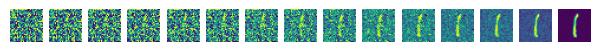

Epoch 14 | Step 200 | Loss: 0.03214428946375847 | C: 2


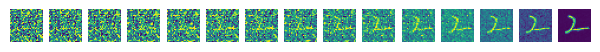

Epoch 14 | Step 300 | Loss: 0.038386955857276917 | C: 3


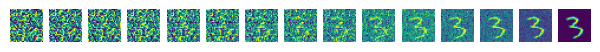

Epoch 14 | Step 400 | Loss: 0.033642612397670746 | C: 4


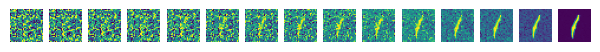

Epoch 15 | Step 000 | Loss: 0.03885302692651749 | C: 5


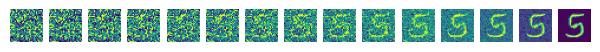

Epoch 15 | Step 100 | Loss: 0.03171387314796448 | C: 6


Epoch 15 | Step 200 | Loss: 0.03075530007481575 | C: 7


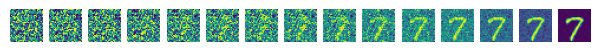

Epoch 15 | Step 300 | Loss: 0.03670600801706314 | C: 8


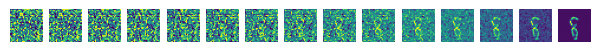

Epoch 15 | Step 400 | Loss: 0.029544958844780922 | C: 9


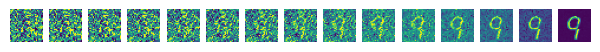

Epoch 16 | Step 000 | Loss: 0.03548295795917511 | C: 0


Epoch 16 | Step 100 | Loss: 0.04039459303021431 | C: 1


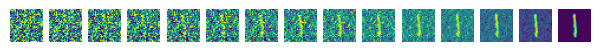

Epoch 16 | Step 200 | Loss: 0.036978356540203094 | C: 2


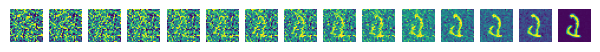

Epoch 16 | Step 300 | Loss: 0.03491433709859848 | C: 3


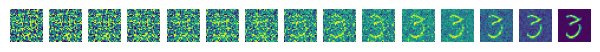

Epoch 16 | Step 400 | Loss: 0.036135926842689514 | C: 4


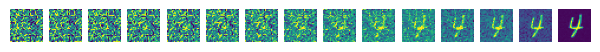

Epoch 17 | Step 000 | Loss: 0.032477423548698425 | C: 5


Epoch 17 | Step 100 | Loss: 0.03230048716068268 | C: 6


Epoch 17 | Step 200 | Loss: 0.034245144575834274 | C: 7


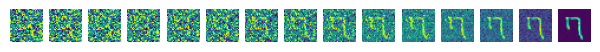

Epoch 17 | Step 300 | Loss: 0.03168823570013046 | C: 8


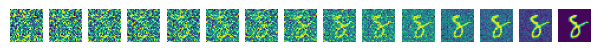

Epoch 17 | Step 400 | Loss: 0.03522304818034172 | C: 9


Epoch 18 | Step 000 | Loss: 0.0357387512922287 | C: 0


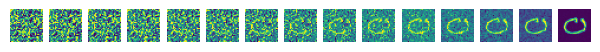

Epoch 18 | Step 100 | Loss: 0.03969789296388626 | C: 1


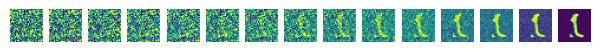

Epoch 18 | Step 200 | Loss: 0.03833899646997452 | C: 2


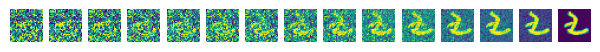

Epoch 18 | Step 300 | Loss: 0.033715199679136276 | C: 3


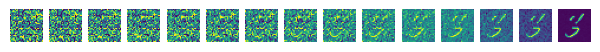

Epoch 18 | Step 400 | Loss: 0.030897466465830803 | C: 4


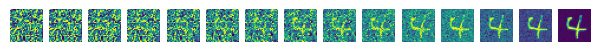

Epoch 19 | Step 000 | Loss: 0.02852911874651909 | C: 5


Epoch 19 | Step 100 | Loss: 0.03435276076197624 | C: 6


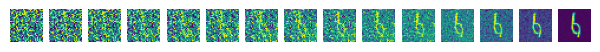

Epoch 19 | Step 200 | Loss: 0.036344073712825775 | C: 7


Epoch 19 | Step 300 | Loss: 0.02922837994992733 | C: 8


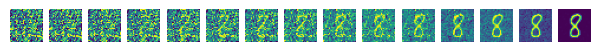

Epoch 19 | Step 400 | Loss: 0.03977354243397713 | C: 9


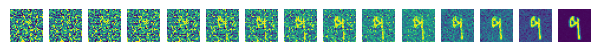

In [336]:
optimizer = Adam(model.parameters(), lr=0.0001)
epochs = 20
ncols = 15  # Should evenly divide T
preview_c = 0
c_drop_prob = 0.1

model.train()
print (model.parameters())
for epoch in range(epochs):
    for step, batch in enumerate(data):
        c_drop_prob = 0.1
        optimizer.zero_grad()

        t = torch.randint(0, T, (len(batch[0]),), device=device).float()
        x = batch[0].to(device)

        c_hot, c_mask = get_context_mask(batch[1], c_drop_prob)
        loss = get_loss(model, x, t, c_hot, c_mask)
        loss.backward()
        optimizer.step()

        if epoch % 1 == 0 and step % 100 == 0:
            class_name = class_names[preview_c]
            print(f"Epoch {epoch} | Step {step:03d} | Loss: {loss.item()} | C: {class_name}")
            c_drop_prob = 0 # Do not drop context for preview
            c_hot, c_mask = get_context_mask(torch.Tensor([preview_c]), c_drop_prob)
            sample_images(model, IMG_CH, IMG_SIZE, ncols, c_hot, c_mask)
            preview_c = (preview_c + 1) % 10


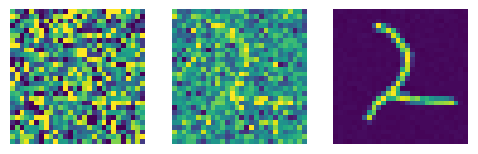

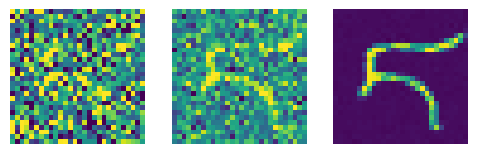

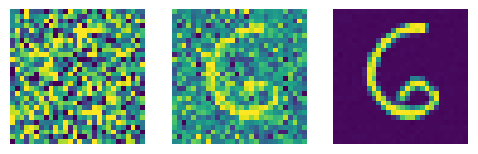

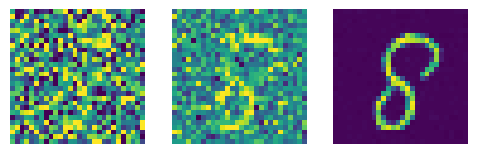

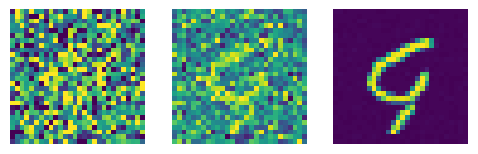

In [337]:
model.eval()
figsize=(8,8) # Change me
ncols = 3 # Should evenly divide T
for i in range(10):
      c_hot, c_mask = get_context_mask(torch.Tensor([i]), c_drop_prob)
      sample_images(model, IMG_CH, IMG_SIZE, ncols, c_hot, c_mask)